In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve, lsqr

from numpy.linalg import cond


import pandas as pd

import pickle
import os.path

# Forcing Terms

In [10]:
def foo1(node):
    return node[0]*2
def exact1(node):
    return node[0]

# l=3
def foo2(node):
    return (node[0]**2 - node[1]**2) * 6
def exact2(node):
    return (node[0]**2 - node[1]**2)

def foo3(node):
    return (node[0]**2 - node[1]**2) * node[2] * 12
def exact3(node):
    return (node[0]**2 - node[1]**2) * node[2]

# Parameters

In [14]:
file_name = 'PHS_survey'

node_sets = ['spiral']
ns = [200 * 2**i for i in range(8)]
#ns = [100, 200]
print(ns)

#rbf_labels = ['r^3', 'r^4*log(r)', 'r^5', 'r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9', 'gaussian']
rbf_labels = ['r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9']
#rbf_labels = ['r^3', 'r^5', 'r^6*log(r)', 'r^9', 'gaussian']
#rbf_labels = ['r^3', 'gaussian']

#epsilons = [1, .5, .25, .1, .05]
epsilons = [1, .05]

foo, exact = foo2, exact2

#stencil_sizes = [7, 11, 31]
stencil_sizes = [11, 31]

[200, 400, 800, 1600, 3200, 6400, 12800, 25600]


# RBFs

In [15]:
rbf_dict = {}

even_tol = 1e-14

def rbf(r):
    return r**3
def d_phi_dr_div_r(r):
    return 3 * r
rbf_dict['r^3'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**2 * (1 + 4*np.log(r))
rbf_dict['r^4*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**5
def d_phi_dr_div_r(r):
    return 5 * r**3
rbf_dict['r^5'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * (1 + 6*np.log(r))
rbf_dict['r^6*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**7
def d_phi_dr_div_r(r):
    return 7 * r**5
rbf_dict['r^7'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**8 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * (1 + 8*np.log(r))
rbf_dict['r^8*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**9
def d_phi_dr_div_r(r):
    return 9 * r**7
rbf_dict['r^9'] = (rbf, d_phi_dr_div_r)

# RBFs with Shape Parameter
shape_rbfs = []

def rbf(r):
    return np.exp(-(epsilon*r)**2)
def d_phi_dr_div_r(r):
    return -2 * epsilon**2 * np.exp(-(epsilon*r)**2)
rbf_dict['gaussian'] = (rbf, d_phi_dr_div_r)
shape_rbfs += ['gaussian']



def grad_rbf(node, node_center):
    r = dist(node, node_center)
    return d_phi_dr_div_r(r) * (np.array(node) - np.array(node_center))

########################################################################################
#
# misc
#
########################################################################################

def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

# Run Code

In [16]:
columns = ['node_set', 'rbf',  'epsilon', 'num_basis', 'N', 'stencil_size', 'max_error', 'rel_L2_error']
data = pd.DataFrame(columns=columns)

for node_set in node_sets:
    for n in ns:
        print('n: %d' % n)
        # generate nodes
        if node_set == 'spiral':
            indices = np.arange(0, n, dtype=float) + 0.5
            phi = np.arccos(1 - 2*indices/n)
            theta = np.pi * (1 + 5**0.5) * indices
            xs, ys, zs = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
            nodes = [(x,y,z) for x,y,z in zip(xs,ys,zs)]
        projectors = [np.eye(3) - np.outer(node, node) for node in nodes]

        # generate stencils
        tree = cKDTree(np.array(nodes))
        

        # generate weights
        for rbf_label in rbf_labels:
            print('\trbf: ' + rbf_label)
            rbf, d_phi_dr_div_r = rbf_dict[rbf_label]
            skip_no_epsilon = False
            for epsilon in epsilons:
                if skip_no_epsilon:
                    continue
                if rbf_label not in shape_rbfs:
                    #epsilon = ''
                    skip_no_epsilon = True
                else:
                    print('\t\t\tepsilon %f' % epsilon)
                
                for stencil_size in stencil_sizes:
                    if stencil_size > n:
                        stencil_size = n
                    stencils = [tree.query(node, stencil_size)[1] for node in nodes]
                    print('\t\tstencil size: %d' % stencil_size)
                    
                    weights = np.zeros((n, stencil_size))
                    row_index = [r for r in range(n) for c in range(stencil_size)]
                    col_index = np.zeros((n, stencil_size))
                    for i, stencil in enumerate(stencils):

                        col_index[i] = stencil
                        nn = [nodes[i] for i in stencil]
                        nn_proj = [projectors[i] for i in stencil]
                        center_x, center_y, center_z = nn[0]

                        A = np.array([[rbf(dist(node, node_center)) for node in nn] for node_center in nn])
                        P = np.array([[1, x-center_x, y-center_y, z-center_z] for x,y,z in nn])
                        AP = np.block([[A,P],[P.T, np.zeros((4,4))]])

                        rhsAs = np.array([ [ nn_proj[j]@grad_rbf(node, node_center) for j, node in enumerate(nn) ] for node_center in nn] )

                        rhsA = rhsAs[:,:,0] # only the x coordinates
                        rhs = np.block([[rhsA],
                                        [np.zeros(stencil_size)],
                                        [1-node[0]**2 for node in nn],
                                        [-node[0]*node[1] for node in nn],
                                        [-node[0]*node[2] for node in nn] ])
                        weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                        weights[i] = (weights_grad@weights_grad)[0]

                        rhsA = rhsAs[:,:,1] # only the y coordinates
                        rhs = np.block([[rhsA],
                                        [np.zeros(stencil_size)],
                                        [-node[0]*node[1] for node in nn],
                                        [1-node[1]**2 for node in nn],
                                        [-node[1]*node[2] for node in nn] ])
                        weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                        weights[i] += (weights_grad@weights_grad)[0]

                        rhsA = rhsAs[:,:,2] # only the z coordinates
                        rhs = np.block([[rhsA],
                                        [np.zeros(stencil_size)],
                                        [-node[0]*node[2] for node in nn],
                                        [-node[1]*node[2] for node in nn],
                                        [1-node[2]**2 for node in nn] ])
                        weights_grad = la.solve(AP, rhs)[:stencil_size,:].T
                        weights[i] += (weights_grad@weights_grad)[0]

                    C = sp.csc_matrix((weights.ravel(), (row_index, col_index.ravel())),shape=(n,n))

                    # solve steady-state
                    C = sp.vstack( [sp.hstack([C, np.ones((n,1))], format='csr'), 
                                    np.block([np.ones((1,n)), np.zeros((1,1))]) ], format='csr')
                    rhs = [-foo(node) for node in nodes] + [0]
                    u = spsolve(C, rhs)
                    u = u[:-1]
                    u_true = np.array([exact(node) for node in nodes])
                    data = data.append( 
                        {'node_set': node_set, 'rbf':rbf_label, 'epsilon': epsilon,
                         'num_basis':np.int(4), 'N':n, 'stencil_size':stencil_size,
                         'max_error':np.max( np.abs(u-u_true ) ), 
                         'rel_L2_error':la.norm((u-u_true)/u_true) }, ignore_index=True)


n: 200
	rbf: r^6*log(r)
		stencil size: 11
		stencil size: 31
	rbf: r^7
		stencil size: 11
		stencil size: 31
	rbf: r^8*log(r)
		stencil size: 11
		stencil size: 31
	rbf: r^9
		stencil size: 11
		stencil size: 31
n: 400
	rbf: r^6*log(r)
		stencil size: 11
		stencil size: 31
	rbf: r^7
		stencil size: 11
		stencil size: 31
	rbf: r^8*log(r)
		stencil size: 11
		stencil size: 31
	rbf: r^9
		stencil size: 11
		stencil size: 31
n: 800
	rbf: r^6*log(r)
		stencil size: 11
		stencil size: 31
	rbf: r^7
		stencil size: 11
		stencil size: 31
	rbf: r^8*log(r)
		stencil size: 11
		stencil size: 31
	rbf: r^9
		stencil size: 11
		stencil size: 31
n: 1600
	rbf: r^6*log(r)
		stencil size: 11
		stencil size: 31
	rbf: r^7
		stencil size: 11
		stencil size: 31
	rbf: r^8*log(r)
		stencil size: 11
		stencil size: 31
	rbf: r^9
		stencil size: 11
		stencil size: 31
n: 3200
	rbf: r^6*log(r)
		stencil size: 11
		stencil size: 31
	rbf: r^7
		stencil size: 11
		stencil size: 31
	rbf: r^8*log(r)
		stencil size: 11


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.516220363603332e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7280921839154352e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1097305514885323e-16 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.05298490318843e-16 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.451121009732084e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.42430158994021e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accu

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1097305304967098e-16 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.7280921766112248e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.516220530873884e-17 / 1.1102230246251565e-16
  RuntimeWarning)


		stencil size: 31


In [17]:
display(data[:10])

,node_set,rbf,epsilon,num_basis,N,stencil_size,max_error,rel_L2_error
0,spiral,r^6*log(r),1,4,200,11,1.240114,100.127567
1,spiral,r^6*log(r),1,4,200,31,0.012386,0.806396
2,spiral,r^7,1,4,200,11,20.742681,3046.183098
3,spiral,r^7,1,4,200,31,0.003279,0.155076
4,spiral,r^8*log(r),1,4,200,11,9.177501,2216.156403
5,spiral,r^8*log(r),1,4,200,31,0.012247,2.310512
6,spiral,r^9,1,4,200,11,16.893192,3993.941604
7,spiral,r^9,1,4,200,31,0.004061,0.746317
8,spiral,r^6*log(r),1,4,400,11,0.548202,188.503019
9,spiral,r^6*log(r),1,4,400,31,0.020902,1.675647


# Write to File

In [18]:
i = 0
file_name_num = file_name + '_' + str(i) + '.pickle'
while os.path.isfile(os.path.join('pickles',file_name_num)):
    i += 1
    file_name_num = file_name + '_' + str(i) + '.pickle'

f = open(os.path.join('pickles',file_name_num), 'wb')
pickle.dump(data, f)
f.close()

# Read from File

In [28]:
file_to_read = 'PHS_survey_0.pickle'
f = open(os.path.join('pickles',file_to_read), 'rb')
read_data = pickle.load(f)
f.close()
read_data['N'] = read_data['N'].apply(pd.to_numeric, errors='coerce')
read_data['label'] = read_data['rbf'] + ' ' + read_data['epsilon'].astype(str)

rbf_labels = read_data.rbf.unique()
stencil_sizes = read_data.stencil_size.unique()
ns = read_data.N.unique()
epsilons = read_data.epsilon.unique()

#read_data['sqrtN'] = np.sqrt(read_data['N'])

In [29]:
display(read_data[:10])

,node_set,rbf,epsilon,num_basis,N,stencil_size,max_error,rel_L2_error,label
0,spiral,r^6*log(r),1,4,200,11,1.240114,100.127567,r^6*log(r) 1
1,spiral,r^6*log(r),1,4,200,31,0.012386,0.806396,r^6*log(r) 1
2,spiral,r^7,1,4,200,11,20.742681,3046.183098,r^7 1
3,spiral,r^7,1,4,200,31,0.003279,0.155076,r^7 1
4,spiral,r^8*log(r),1,4,200,11,9.177501,2216.156403,r^8*log(r) 1
5,spiral,r^8*log(r),1,4,200,31,0.012247,2.310512,r^8*log(r) 1
6,spiral,r^9,1,4,200,11,16.893192,3993.941604,r^9 1
7,spiral,r^9,1,4,200,31,0.004061,0.746317,r^9 1
8,spiral,r^6*log(r),1,4,400,11,0.548202,188.503019,r^6*log(r) 1
9,spiral,r^6*log(r),1,4,400,31,0.020902,1.675647,r^6*log(r) 1


In [30]:
#read_data[(read_data.N==1280) & (read_data.stencil_size==31)].plot(
#        kind='bar', x=['rbf', 'epsilon'], y='rel_L2_error')

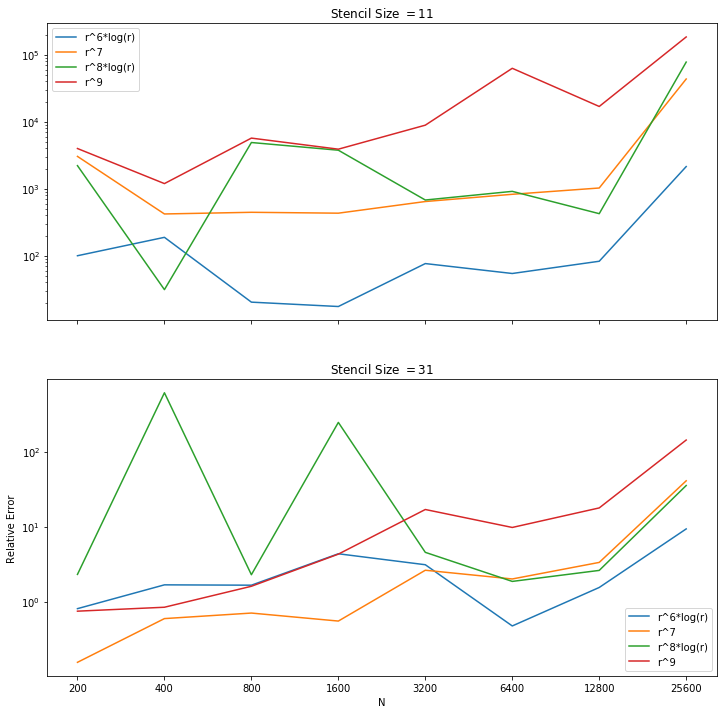

In [31]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))

for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.epsilon==1)]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'rel_L2_error', data=read_data_stencil[read_data_stencil.rbf==rbf])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.show()

Text(0,0.5,'Relative Error')

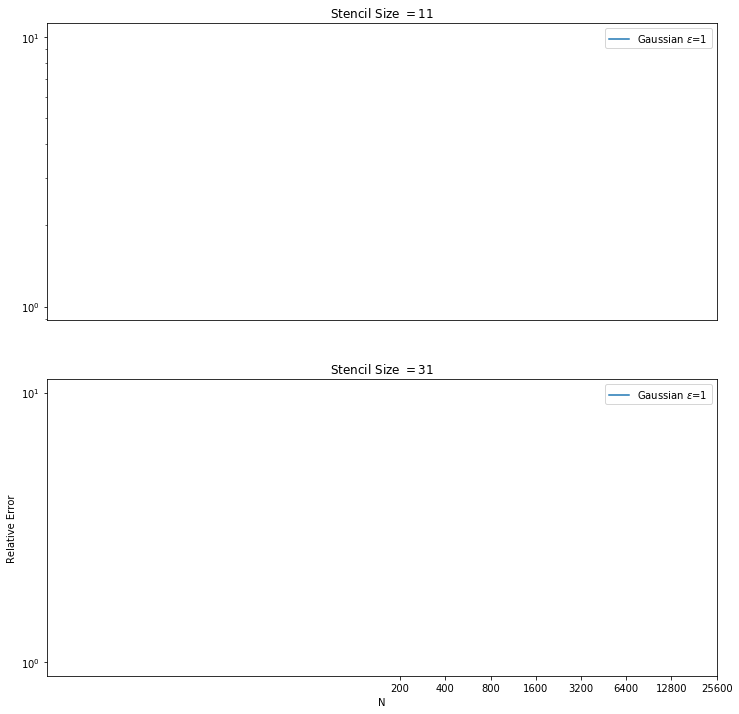

In [32]:
fig, ax_s = plt.subplots(len(stencil_sizes), sharex=True, figsize=(12,12))


for i, k in enumerate(stencil_sizes):
    legends = []
    read_data_stencil = read_data[(read_data.stencil_size==k) & (read_data.rbf=='gaussian')]
    for epsilon in epsilons:
        ax_s[i].loglog( 'N', 'rel_L2_error', data=read_data_stencil[read_data_stencil.epsilon==epsilon])
        ax_s[i].set_title('Stencil Size $=' + str(k) + '$')
    ax_s[i].legend( ['Gaussian $\epsilon$=%s' % epsilon for epsilon in epsilons] )

plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')

#plt.show()